# CIFAR10 Image Classification

In this learning pathway, we will explore and classify images from the CIFAR10 dataset. It consists of 60,000 32x32 colored images that represent 10 different objects or classes. Each image has an associated label indicating the class it belongs to. Our objective as data scientists is to predict the class label of the images. We will accomplish this by creating a ML model that predicts the object in each image. We'll first explore the data, create a baseline model, and improve it over the course of this learning pathway. 

## Table of contents
1. [Load cifar10 datasets](#load-cifar10-datasets)
2. [Visualize random samples](#visualize-random-samples)
3. [Prepare images for model training](#prepare-images-for-model-training)
4. [Build a baseline model](#build-a-baseline-model)
5. [Improving the Model](#improve-the-model)
6. [Additional Suggestions](#additional-suggestions)

In [1]:
# install requirements
!pip install -q -r requirements.txt


[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load cifar10 datasets

Since classifying images in the cifar10 dataset is the "Hello World" of object dectection tasks, the dataset is widely accessible on the Internet and there are several ways that one can import the dataset into their workspace. Here we are using the tensorflow_datasets (tfds) API to load the dataset, split it into training and testing sets, shuffle the images in each set, and store them into our dataset folder.

In [3]:
(cifar10_train, cifar10_test), cifar10_info  = tfds.load(
        'cifar10',
        split=['train', 'test'],
        data_dir='./dataset', # store in dataset folder
        shuffle_files=True, # load in random order
        as_supervised=True, # include labels
        with_info=True, # include info
    )

# Visualize random samples

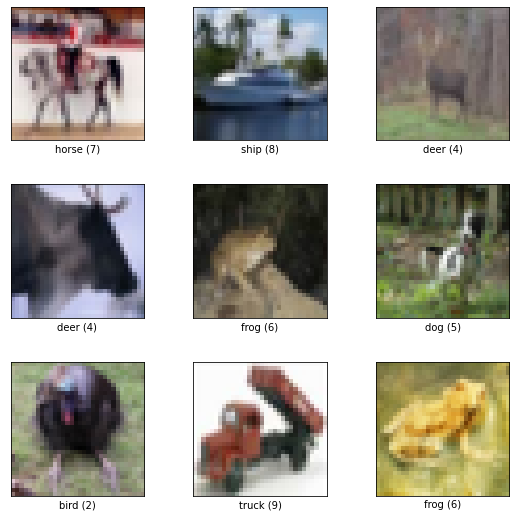

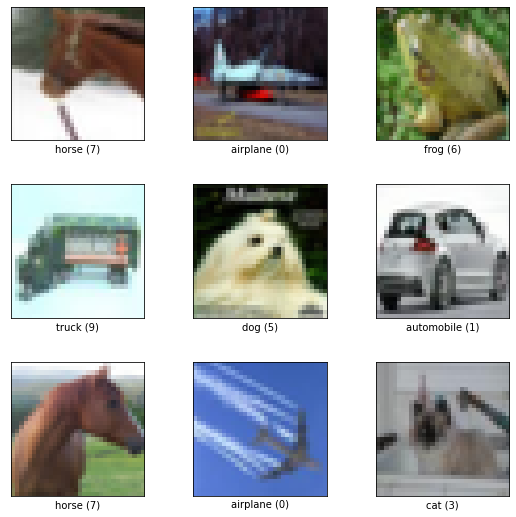

In [4]:
# visualize random samples from both the training and testing dataset
fig_train = tfds.show_examples(cifar10_train, cifar10_info)
fig_test = tfds.show_examples(cifar10_test, cifar10_info)
plt.show()  # Display the plots

# Prepare images for model training
1) Recasting data types - TFDS provides images of data type int8 while the model expects data type float32 so it is necessary to transform the data.

2) Normalization - it is a common practice to normalize data, i.e rescale its values to [0, 1], before inputting them into the model for training. When data is assigned to a similar range, it allows gradient descents to converge faster, reducing the time it takes for model to train. 

The following data preparation steps are based on boilerplate code that TensorFlow provided which you read more about [here](https://www.tensorflow.org/datasets/keras_example).

In [5]:
def normalize_img(image, label):
    """ Takes image as an input and casts its pixels that are int8 values into float32 values"""
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# prepare both the training and testing datasets
cifar10_train = cifar10_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_train = cifar10_train.cache()    
cifar10_train = cifar10_train.shuffle(cifar10_info.splits['train'].num_examples)
cifar10_train = cifar10_train.batch(32)  
cifar10_train = cifar10_train.prefetch(tf.data.AUTOTUNE)

cifar10_test = cifar10_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_test = cifar10_test.batch(32)   
cifar10_test = cifar10_test.cache()
cifar10_test = cifar10_test.prefetch(tf.data.AUTOTUNE)

# Build baseline model

Let's create a baseline model so that we have a point of reference we can compare our subsequent models to. This model is a Sequential model. In order words, each layer sends its outputs to all inputs of the layer that follows it. Notice that we are stacking different layers on top of each other. Let's explore and define each layer and its associated parameters.

First, we must tell our model what the shape of each image is so it knows what to expect. Each image is 32x32 with 3 color changes which we can represent in vector form (32, 32, 3) in our model. The first layer in our model is Flatten() layer which flattens our input vector to 3072 dimensional vector. The next layer is a Dense() layer with 128 neurons that reciveves inputs from the previous Flatten() layer and activates them according to a ReLu activation function. The last layer is another Dense() layer with 10 output channels to classify the 10 classes. 

### Flatten
* A layer that flattens a multi-dimensional output into a single-dimensional output

### Dense
* Dense layers are the basic classification layers
* They receive input and determine which parts of the input are important to classify data based on the outputs at the end through mapping the input to an activation function

In [7]:
model = tf.keras.models.Sequential([
        keras.Input(shape=(32, 32, 3)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

Now that we've created model, we need to compile it and define the optimizer, loss function, and accuracy metric. Here, we are choosing to use Adam as our optimizer which is an extension on Stochastic Gradient Descent. Next, we are choosing Sparse Categorical Cross Entropy loss as our loss function which is typically used for classification problems where the labels are coded as integers. Lastly, we are choosing Sparse Categorical Accuracy as our accuracy metric. The math behind each of these parameters is beyond the scope of this learning pathway, so please refer to the following resources for a more granular explanation:

* Adam Optimizer: https://towardsdatascience.com/complete-guide-to-adam-optimization-1e5f29532c3d
* Sparse Categorical Cross Entropy Loss: https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
* Sparse Categorical Accuracy: https://neptune.ai/blog/keras-metrics


In [8]:
 model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

Before we train our model, let's take a high level view of its structure and get some insight into how each of its layers interact with each other.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


Finally, let's train our model for 10 epochs or how many passes of the entire training dataset we want to train the model on.

In [10]:
history = model.fit(
        cifar10_train,
        epochs=10,
        validation_data=cifar10_test
    )

Epoch 1/10
1563/1563 [==============================] - 18s 6ms/step - loss: 1.8882 - sparse_categorical_accuracy: 0.3211 - val_loss: 1.7487 - val_sparse_categorical_accuracy: 0.3684
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.7457 - sparse_categorical_accuracy: 0.3734 - val_loss: 1.7181 - val_sparse_categorical_accuracy: 0.3907
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6972 - sparse_categorical_accuracy: 0.3909 - val_loss: 1.6899 - val_sparse_categorical_accuracy: 0.3997
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6708 - sparse_categorical_accuracy: 0.4005 - val_loss: 1.6465 - val_sparse_categorical_accuracy: 0.4155
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6502 - sparse_categorical_accuracy: 0.4094 - val_loss: 1.6620 - val_sparse_categorical_accuracy: 0.4066
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6355 - spar

# Evaluate model

Let's visualize our loss and accuracy for our training and testing datasets.

In [11]:
def plot_diagnostics(history):
    """Plot loss and accuracy for model training and testing at each epoch""" 
     # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='test')
    plt.tight_layout()
    plt.show()

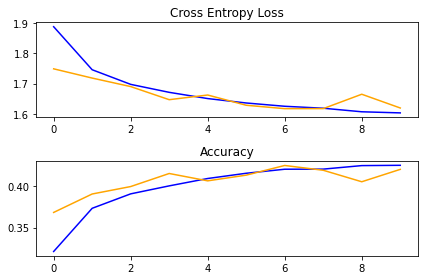

In [12]:
plot_diagnostics(history)

Our baseline model is only able to achieve an accuracy 43.91% on the testing dataset. Clearly, we can do much better. In the following section, we'll explore different techniques to gradually improve the accuracy of our model. 

# Improving the model
Let's add more hidden layers to our neural network. Specifically, we'll be using a VGG based archeitectuture that was popularized in the 2015 paper, [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556](https://arxiv.org/abs/1409.1556). It was found that stacking convolutional layers with max pooling layers performs well for image classification.

### Conv2D
* Applies a filter over the image to discover its most important features such as edges and spaces

### MaxPooling2D
* Summarizes how well different regions of the image fit to the filter from the previous layer

In [13]:
model1 = tf.keras.models.Sequential() 

model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3)))
model1.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dense(10, activation='softmax'))

model1.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [14]:
history1 = model1.fit(
        cifar10_train,
        epochs=10,
        validation_data=cifar10_test
    )

Epoch 1/10


/opt/app-root/lib64/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 118s 75ms/step - loss: 1.3212 - sparse_categorical_accuracy: 0.5321 - val_loss: 1.1133 - val_sparse_categorical_accuracy: 0.6134
Epoch 2/10
1563/1563 [==============================] - 117s 75ms/step - loss: 0.9769 - sparse_categorical_accuracy: 0.6596 - val_loss: 1.0145 - val_sparse_categorical_accuracy: 0.6458
Epoch 3/10
1563/1563 [==============================] - 116s 74ms/step - loss: 0.8450 - sparse_categorical_accuracy: 0.7046 - val_loss: 0.9673 - val_sparse_categorical_accuracy: 0.6599
Epoch 4/10
1563/1563 [==============================] - 116s 74ms/step - loss: 0.7372 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.9952 - val_sparse_categorical_accuracy: 0.6741
Epoch 5/10
1563/1563 [==============================] - 116s 74ms/step - loss: 0.6439 - sparse_categorical_accuracy: 0.7757 - val_loss: 0.9898 - val_sparse_categorical_accuracy: 0.6724
Epoch 6/10
1563/1563 [==============================] - 115s 74ms/step - loss: 0.5578 

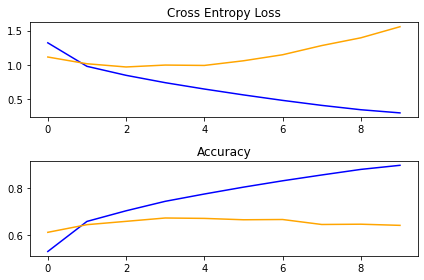

In [15]:
plot_diagnostics(history1)

Although both our training and validation accuracy improved, there appears to be a large gap between the diagonistic curves of the two datasets. The loss and accuracy of our model improved much more for our training dataset compared to our validation, indicating that the model is overfitting to the training data. Let's explore some techniques to prevent overfitting.

### Dropout
* Large neural nets trained on small datasets tend to overfit to training data
* The dropout randomly removes a percentage of outputs from each layer during training to prevent overfitting or the nodes becoming too specialized to the training dataset


In [16]:
model2 = tf.keras.models.Sequential() 
model2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),input_shape=(32, 32, 3)))
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(rate=0.5))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [17]:
history2 = model2.fit(
        cifar10_train,
        epochs=10,
        validation_data=cifar10_test
    )

Epoch 1/10
1563/1563 [==============================] - 115s 74ms/step - loss: 1.5551 - sparse_categorical_accuracy: 0.4369 - val_loss: 1.1992 - val_sparse_categorical_accuracy: 0.5876
Epoch 2/10
1563/1563 [==============================] - 114s 73ms/step - loss: 1.2268 - sparse_categorical_accuracy: 0.5683 - val_loss: 1.0578 - val_sparse_categorical_accuracy: 0.6362
Epoch 3/10
1563/1563 [==============================] - 115s 74ms/step - loss: 1.1102 - sparse_categorical_accuracy: 0.6083 - val_loss: 0.9826 - val_sparse_categorical_accuracy: 0.6585
Epoch 4/10
1563/1563 [==============================] - 115s 74ms/step - loss: 1.0274 - sparse_categorical_accuracy: 0.6371 - val_loss: 0.9677 - val_sparse_categorical_accuracy: 0.6647
Epoch 5/10
1563/1563 [==============================] - 114s 73ms/step - loss: 0.9798 - sparse_categorical_accuracy: 0.6533 - val_loss: 0.9454 - val_sparse_categorical_accuracy: 0.6746
Epoch 6/10
1563/1563 [==============================] - 114s 73ms/step - lo

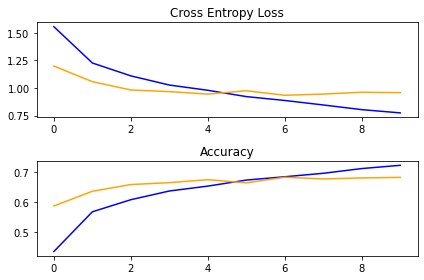

In [18]:
plot_diagnostics(history2)

In [23]:
model3 = tf.keras.models.Sequential() 

# padding adds a border of 0s to the image so that our filter does not fall out of bounds
model3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', input_shape=(32, 32, 3)))
model3.add(tf.keras.layers.Conv2D(32, kernel_size =(3, 3), padding = 'same', activation='relu'))
model3.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model3.add(tf.keras.layers.Dropout(0.2))

model3.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation = "relu")) 
model3.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation = "relu")) 
model3.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model3.add(tf.keras.layers.Dropout(rate=0.3))

model3.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation = "relu"))
model3.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation = "relu"))
model3.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2)))
model3.add(tf.keras.layers.Dropout(rate=0.4))

model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dropout(rate=0.5))
model3.add(tf.keras.layers.Dense(10, activation='softmax'))

model3.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [25]:
history3 = model3.fit(
        cifar10_train,
        epochs=10,
        validation_data=cifar10_test
    )

Epoch 1/10
1563/1563 [==============================] - 327s 209ms/step - loss: 1.6727 - sparse_categorical_accuracy: 0.3807 - val_loss: 1.2688 - val_sparse_categorical_accuracy: 0.5409
Epoch 2/10
1563/1563 [==============================] - 326s 208ms/step - loss: 1.2692 - sparse_categorical_accuracy: 0.5463 - val_loss: 0.9814 - val_sparse_categorical_accuracy: 0.6464
Epoch 3/10
1563/1563 [==============================] - 326s 208ms/step - loss: 1.0999 - sparse_categorical_accuracy: 0.6137 - val_loss: 0.9249 - val_sparse_categorical_accuracy: 0.6735
Epoch 4/10
1563/1563 [==============================] - 326s 208ms/step - loss: 1.0094 - sparse_categorical_accuracy: 0.6481 - val_loss: 0.9153 - val_sparse_categorical_accuracy: 0.6673
Epoch 5/10
1563/1563 [==============================] - 326s 209ms/step - loss: 0.9494 - sparse_categorical_accuracy: 0.6708 - val_loss: 0.8118 - val_sparse_categorical_accuracy: 0.7175
Epoch 6/10
1563/1563 [==============================] - 327s 209ms/ste

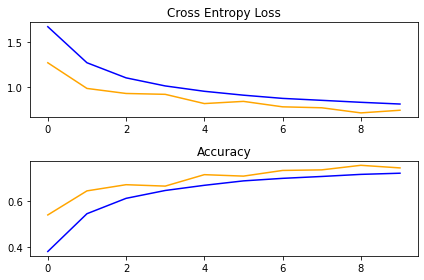

In [27]:
plot_diagnostics(history3)

# Additional Suggestions
* Changing the # of epochs and batch size
* Batch normalization
* Data augmentation
* Using a pretrained model